#  Script Thesis - Droughts and Decisions
##### *NDVI & Precipitation plots and the ROC Diagram*

## Index
* [Import tools and Data](#Import-tools-and-Data)
* [Functions for NDVI and Precipitation graphs](#Functions-for-NDVI-and-Precipitation-graphs)
* [Mean and Cumm Precip and Evap Reanalysis Data](#Mean-and-Cumm-Precip-and-Evap-Reanalysis-Data)
* [Mean NDVI and P - E over study area](#Mean-NDVI-and-P---E-over-study-area)
* [NDVI and Precipitation Results Plots](#NDVI-and-Precipitation-Results-Plots)
* [Forecast Bias Correction](#Forecast-Bias-Correction)
* [ROC-diagram per threshold](#ROC-diagram-per-threshold)
* [Bootstrapping](#Bootstrapping)
* [Plotting FC values against RE values](#Plotting-FC-values-against-RE-values)

## Import tools and Data

In [1]:
%matplotlib inline
from netCDF4 import Dataset
import netCDF4
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import regionmask
import rasterio
import fiona
from shapely.geometry import Polygon, MultiPolygon, shape, mapping
import datetime as dt
from datetime import date
import statsmodels.api as sm
import pandas as pd
from pandas import DataFrame
from scipy import stats
from sklearn.metrics import auc
import seaborn as sns
import scipy.interpolate as intp
from scipy import arange, array, exp

In [2]:
#Open Data
#ERA5 - Reanalysis
folder = r'D:\Thesis_Dschijf\Data\era5'
fn_template = 'era5_{:d}{:02d}.nc'
years = range(1993, 2020)
months = range(1, 13)
ds_list = []
for year in years:
    for month in months:
        fn = os.path.join(folder, fn_template.format(year, month))
#         print(fn)
        try:
            ds_list.append(xr.open_dataset(fn, chunks={'latitude': 4, 'longitude': 4, 'time': 2400}, drop_variables= ('t2m', 'd2m')))
        except:
            print('file {:s} not found'.format(fn))
ds_era5_big = xr.concat(ds_list, dim='time')
ds_era5 = ds_era5_big.sel(longitude=slice(36.7, 37.4), latitude=slice(-2.6, -3))

file D:\Thesis_Dschijf\Data\era5\era5_201908.nc not found
file D:\Thesis_Dschijf\Data\era5\era5_201909.nc not found
file D:\Thesis_Dschijf\Data\era5\era5_201910.nc not found
file D:\Thesis_Dschijf\Data\era5\era5_201911.nc not found
file D:\Thesis_Dschijf\Data\era5\era5_201912.nc not found


In [3]:
#Open Data
#S5 forecast data
folder = r'D:\Thesis_Dschijf\Data\forecasts\forecast_era5'
fn_template = 'ecmwf_s5_{:d}.nc'
years = range(1993, 2020)
ds_FC = []
for year in years:
    fn = os.path.join(folder, fn_template.format(year))
    try:
        ds_FC.append(xr.open_dataset(fn, chunks={'latitude': 1, 'longitude': 1}))
    except:
        print('file {:s} not found'.format(fn))

In [4]:
#Open Data 
#NDVI data
folder = r'D:\Thesis_Dschijf\Data\ndvi_gimms\ndvi_gimms'
d_ndvi = []
for year in range(2001, 2020):
    fn2 = os.path.join(folder, 'ndvi_{:d}.nc'.format(year))
    try:
        d_ndvi.append(xr.open_dataset(fn2))
    except:
        print('file {:s} not found'.format(fn2))

In [5]:
#make the NDVI data smaller (only fieldwork area) to load faster
ndvi_small = []
for x in range(0,19):
    ndvi_small.append(d_ndvi[x].sel(lat=slice(-2.6, -3), lon=slice(36.7, 37.4)))

In [6]:
#mask out the no-data (>250) values
NDVI = []
for x in range(0,19):
    NDVI.append(((ndvi_small[x].where(ndvi_small[x]<250.))) * 0.004)

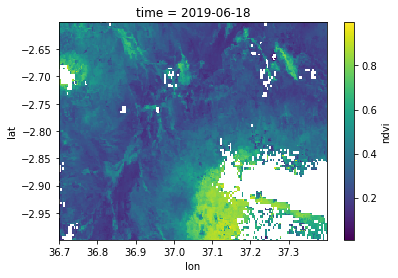

In [7]:
#obtain an impression what the NDVI data looks like
NDVI[18]['ndvi'][21].plot.imshow()

In [8]:
#make one big Dataset for the NDVI data
ndvi_all = xr.concat(NDVI, dim='time')

## Functions for NDVI and Precipitation graphs

In [9]:
# function for mean over study area for reanalysis and FC Data
def mean_SA_era5(s1):
    data = s1[:,:,:]
    mean_data = data.mean(dim = 'latitude')
    mean_data = mean_data.mean(dim = 'longitude')
    return mean_data

In [10]:
# function for mean over study area for NDVI Data
def mean_SA_ndvi(s1):
    ndvi_data = s1['ndvi']
    data = ndvi_data[:,:,:]
    mean_data = data.mean(dim = 'lat')
    mean_data = mean_data.mean(dim = 'lon')
    return mean_data

In [11]:
#Create Mask for fieldwork area

def fiona_feats(fn):
    """
    turn shapes in shapefile into a list of GeoJSON strings, and return values in key in separate list
    """
    ds = fiona.open(fn)
    feats = [feat['geometry'] for feat in ds]
    ds.close()
    return feats
    
def feats2json(feats):
    """
    Change list of shapes into GeoJSON strings
    """
    return [str(shape(feat)) for feat in feats]

def fiona_keyvalue(fn, key):
    """
    Return a list of values belonging to provided key in shapefile
    """
    ds = fiona.open(fn)
    return [feat['properties'][key] for feat in ds]

def request_e2o(baseurl, bbox, time="2013-11-19T13:54:38.987Z/2014-09-10T00:00:00.000Z"):
    """
    
    """
    res = requests.post('https://wci.earth2observe.eu/portal/app/prep_download?', 
                    data={"baseurl":"https://wci.earth2observe.eu/thredds/wcs/jrc/mswep-rainf-daily-agg.nc",
                          "coverage":"Rainf",
                          "type":"file",
                          "bins":"",
                          "time":"2013-11-19T13:54:38.987Z/2014-09-10T00:00:00.000Z",
                          "bbox":"POLYGON((20.654 -15.293,10.986 -24.082,21.006 -26.367,31.201 -21.797,27.158 -15.117,23.291 -15.469,17.842 -15.469,20.654 -15.293))",
                          "graphXAxis": None,
                          "graphYAxis": None,
                          "graphZAxis":"Rainf"})

def cut_xarray(ds, var, extent):
    """
    Make a geographically bounded cut out of a specific variable in an xarray dataset
    Input:
        ds: xarray dataset
        var: - string variable name
        extent: tuple containing extent as (xmin, xmax, ymin, ymax)
    """
    ds_var = ds[var]
    xmin, xmax, ymin, ymax = extent
    return ds_var.sel(lat=slice(ymax, ymin), lon=slice(xmin, xmax)) # .isel(time=slice(0, 10))

def prepare_mask(fn, names_key, abbrev_key):
    """
    Read in a polygon shapefile (or any other fiona compatible file)
    and returns a regionmask object
    Input:
        fn: - string filename
        names_key: - shapefile attribute with names of polygons
        abbrev_key: - shapefile attribute with abbreviated names of polygons (can be the same as names_key)
    Returns:
        regionmask object
    """
    pols = fiona_feats(fn)
    names = fiona_keyvalue(fn, names_key)
    numbers = range(len(names))  # make a list of numbers, one for each province starting from 0
    abbrevs = fiona_keyvalue(fn, abbrev_key)
    # turn shapefile into a regionmask object
    return regionmask.Regions_cls('Tanzania', numbers, names, abbrevs, [shape(poly) for poly in pols])

In [12]:
#extract masked aggregated timeseries

def region_ts_from_ds(ds, mask, stepsize=100, return_as_df=False, unit_multiplier=(1)):
    """
    Extracts an aggregated time series from a xarray ds using a polygon regionmask object
    Inputs:
        ds: xarray dataset (containing one variable)
        mask: polygon regionmask object
        stepsize=100: stepsize for which data should be retrieved. This retrieval only happens when data is returned as pandas dataframe
        return_as_df=False: if set to true, data is retrieved and stored in pandas dataframe, if false, it is provided as a xarray object
    """
    mask_grid = mask.mask(ds)  # convert polygon mask to grid mask
    ds_region = ds.groupby(mask_grid).mean('stacked_lat_lon')*unit_multiplier
    ids = np.unique(mask_grid.values)
    ids = list(np.array(ids[np.isfinite(ids)], dtype='int').flatten())
    names_select = np.array(mask.names)[ids]
    abbrev_select = np.array(mask.abbrevs)[ids]
    ds_region.coords['abbrevs'] = ('region', abbrev_select)
    ds_region.coords['names'] = ('region', names_select)
    ds_region.coords['ids'] = ('region', ids)
    if return_as_df:
        # retrieve all data from xarray ds and return as a pandas dataframe
        df = pd.DataFrame()
        # prepare the dataframe slice by slice (otherwise dask hits an I/O error for some reason)
        ts = 0
        while ts < len(ds_region):
            # this loop is needed because larger chunks give a I/O error with dask / xarray! In later versions this bug is likely to be resolved
            ts += stepsize
            print(ts)
            _df = ds_region.isel(time=slice(ts - stepsize, ts)).to_dataframe() # .drop([region, abbrevs, names]).to_dataframe()
            df = df.append(_df)
        return df
    else:
        return ds_region
        # leave the data as an xarray object (i.e. retrieval still needs to be done)

In [13]:
#Create a tiff file from the selected NDVI data

def write_tiff(fn, darray, nodata=-9999.):
    from rasterio.transform import Affine
    y = darray.lat.values
    x = darray.lon.values
    Z = np.flipud(darray.values)
#    Z = (darray.values)
    Z[np.isnan(Z)] = nodata
    res = (x[-1] - x[0])/(len(x)-1)
#     import pdb;pdb.set_trace()
    transform = Affine.translation(x[0] - res / 2, y[-1] - res / 2) * Affine.scale(res, res)
    new_dataset = rasterio.open(fn,
                                'w',
                                driver='GTiff',
                                height=Z.shape[0],
                                width=Z.shape[1],
                                count=1,
                                dtype=Z.dtype,
                                crs='+proj=latlong',
                                transform=transform,
                                nodata=nodata
                               )
    new_dataset.write(Z, 1)
    new_dataset.close()

# test for write_tiff
test_fn = r'D:\Thesis_Dschijf\NDVI\NDVI_18_20_test.tif'
d = NDVI[18]
d_0 = d['ndvi'][20]
#write_tiff(test_fn, d_0, nodata=-9999.)

In [14]:
#Plot all years
def plot_all(s,ymin,ymax, rows, cols):
    fig = plt.figure(figsize = (15,15))
    fig.subplots_adjust(hspace=0.6, wspace=0.3) 
    for n, series in enumerate(s):
        plt.ylim([ymin,ymax])
        plt.subplot(rows, cols,n+1)
        plt.ylim([ymin,ymax])
        plt.grid(True)
        series.plot() 
    return fig

In [15]:
#Plot per year for the fieldwork area shapefiles
def ndvi_yr_area(year, aspect, size):
    yr = year - 2000 - 1
    mask_area = prepare_mask(r'D:\Thesis_Dschijf\NDVI\StudyArea.shp', 'Name', 'Name')
    NDVI_yr_area = region_ts_from_ds(NDVI[yr]['ndvi'], mask_area, return_as_df=False) 
    fig = xr.plot.line(NDVI_yr_area, x='time', aspect = aspect, size = size)
    return fig

def ndvi_yr_WMA(year, aspect, size):
    yr = year - 2000 - 1
    mask_area = prepare_mask(r'D:\Thesis_Dschijf\NDVI\WMA.shp', 'Name', 'Name')
    NDVI_yr_area = region_ts_from_ds(NDVI[yr]['ndvi'], mask_area, return_as_df=False) 
    fig = xr.plot.line(NDVI_yr_area, x='time', aspect = aspect, size = size)
    return fig

In [16]:
# create threshold function
def threshold(s1,x):
    out = s1 >= x
    return out 

## Mean and Cumm Precip and Evap Reanalysis Data

In [17]:
#cummulative Total Precipitation (TP) in a day instead of per hour
ds_TP = ds_era5.resample(time='24H').sum()['tp']

#cummulative Evaporation (E) in a day instead of per hour
ds_E = ds_era5.resample(time='24H').sum()['e']

In [18]:
# P + E
ds_P_E = ds_TP + ds_E
ds_P_E.load()

<xarray.DataArray (time: 9678, latitude: 2, longitude: 3)>
array([[[-1.6856822e-04, -1.1364396e-03, -1.6894843e-04],
        [ 1.4459970e-04,  1.0961914e-03,  2.9327397e-03]],

       [[-4.4878654e-04, -1.2749550e-03,  6.2421197e-05],
        [ 1.0284403e-03,  4.2654783e-03,  6.9026896e-03]],

       [[-5.4811919e-04, -1.0646398e-03,  1.3420545e-04],
        [-8.9246174e-04,  1.3355848e-03,  3.1497225e-03]],

       ...,

       [[-7.7757554e-04, -1.8411824e-03, -2.6966326e-03],
        [-6.4625562e-04, -1.6673873e-03, -2.6416886e-03]],

       [[-8.9382275e-04, -2.1973839e-03, -3.5700710e-03],
        [-7.3940062e-04, -2.0577337e-03, -3.7248859e-03]],

       [[-2.5717134e-05, -8.8141285e-05, -1.5650346e-04],
        [-8.3805789e-06, -6.5583459e-05, -1.3806297e-04]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-07-01
  * latitude   (latitude) float32 -2.75 -3.0
  * longitude  (longitude) float32 36.75 37.0 37.25

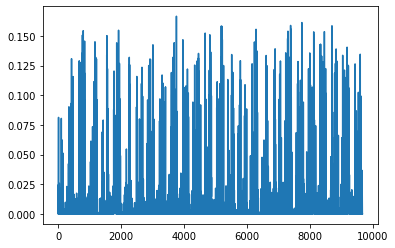

In [19]:
#Make the negative values (due to higher E than P) zero
ds_P_E_0 = xr.where(ds_P_E[:,:,:]<0, 0, ds_P_E)

#plot an example to see what it looks like
Pix1 = ds_P_E_0[:,1,2]
plt.plot(Pix1)

In [20]:
# calculate rolling cummulative for x days
c_P_E_0 = ds_P_E_0.rolling(time=5).sum()
c_P_E_00 = xr.where(c_P_E_0[:,:,:]<0, 0, c_P_E_0) #because issue with floating point not being completely zero

## Mean NDVI and P - E over study area 

In [21]:
# Calculating the mean P, E, over a study area
cTPE = mean_SA_era5(c_P_E_00)

C:\Users\esmee\Anaconda3\lib\site-packages\xarray\core\nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [22]:
#check whether the data is realistic
cTPEf = cTPE[np.isfinite(cTPE)]
print("Min cTPEf = ", min(cTPEf)) 
print("Max cTPEf = ", max(cTPEf))

Min cTPEf =  <xarray.DataArray ()>
array(1.2805685e-09, dtype=float32)
Coordinates:
    time     datetime64[ns] 1993-03-06
Max cTPEf =  <xarray.DataArray ()>
array(0.2866415, dtype=float32)
Coordinates:
    time     datetime64[ns] 2013-04-03


From this we can conclude that there is never a day where no rainfall is recorded over the 6 pixels.
Additionally, the maximum precipitation which fell over a period of 5 days is higher than the climate numbers propose falls in one month in total (0.15m) in Longido in April (month with highest precipitation).
This is all obviously very strange, and makes using the reanalysis over this area doubtful. 

In [23]:
#calculate mean NDVI over study area for each year
m_ndvi = []
for ds in NDVI:
    m_ndvi.append(mean_SA_ndvi(ds))

C:\Users\esmee\Anaconda3\lib\site-packages\xarray\core\nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [24]:
#calculate mean NDVI over the two selected polygons for all years
mask_area = prepare_mask(r'D:\Thesis_Dschijf\NDVI\StudyArea.shp', 'Name', 'Name')
NDVI_yrs_area = region_ts_from_ds(ndvi_all['ndvi'], mask_area, return_as_df=False)

#calculate mean NDVI over the two selected polygons per year
#use ndvi_yr_area definition

#calculate mean NDVI over WMA area for all years
mask_WMA = prepare_mask(r'D:\Thesis_Dschijf\NDVI\WMA.shp', 'Name', 'Name')
NDVI_yrs_WMA = region_ts_from_ds(ndvi_all['ndvi'], mask_WMA, return_as_df=False)

#caluculate mean NDVI over WMA area per year
#use ndvi_yr_WMA definition

## NDVI and Precipitation Results Plots

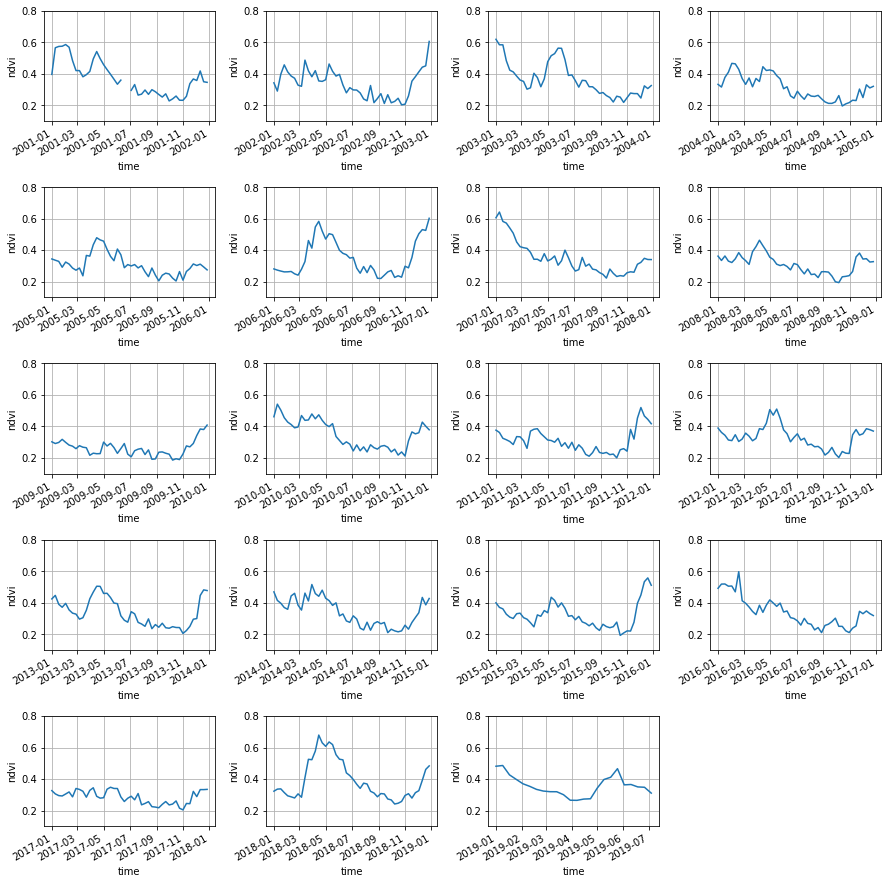

In [25]:
# plot ndvi
fig = plot_all(m_ndvi, 0.1, 0.8, 5, 4)

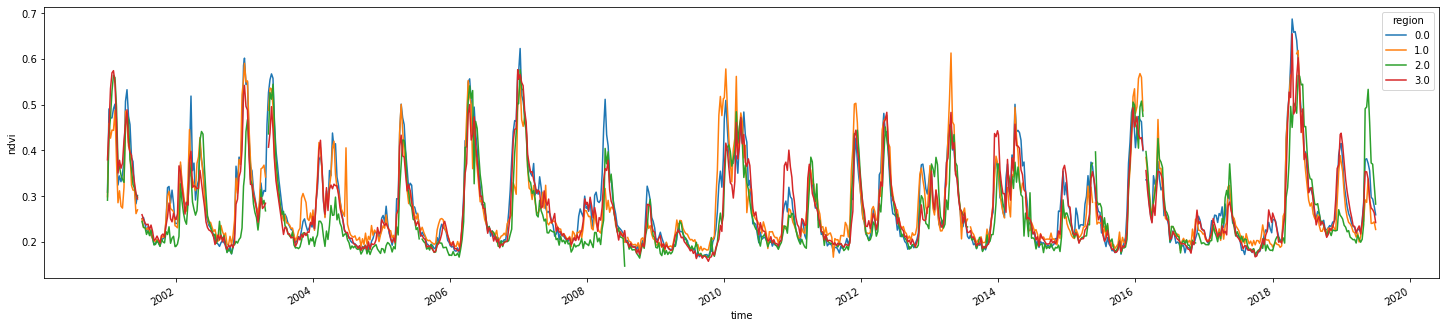

In [26]:
# plot ndvi shapefile areas all year
xr.plot.line(NDVI_yrs_area, x='time', aspect = 5, size = 5)

In the graph above the colors represent the following areas:
* Blue = WMA
* Orange = village land
* Green = flood area

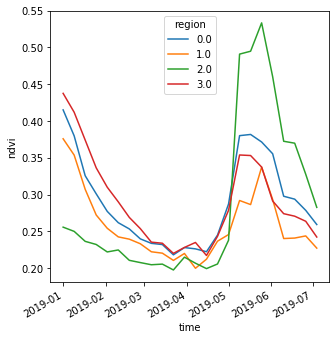

In [27]:
# plot ndvi shapefile areas for 1 year
ndvi_yr_area(2019, 1, 5)

In [28]:
#load data to plot both series
plot1 = NDVI_yrs_WMA.load()
plot2 = cTPE.load()
plot2.rename('Precipitation')

<xarray.DataArray 'Precipitation' (time: 9678)>
array([       nan,        nan,        nan, ..., 0.01305221, 0.00650365,
       0.00013643], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-07-01

Text(0.5, 1.0, 'NDVI and 5-Day Cummulative precipitation 1993-2019')

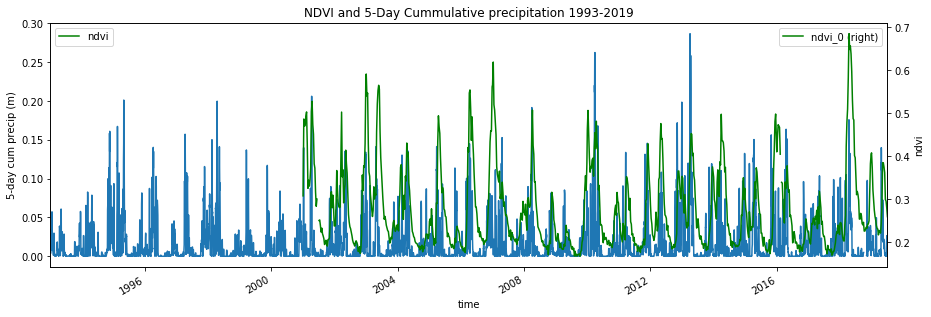

In [29]:
#Plot NDVI over WMA fieldwork area with the reanalysis precipitation data

ax = plt.axes()
plot2.plot(ax=ax)
    
#create library of seperate regions for range(x) x=nr of regions
df1 = pd.DataFrame({'ndvi_{:d}'.format(i): plot1.sel(region=i).to_dataframe()['ndvi'] for i in range(1)}) 
df1.plot(ax=ax, secondary_y=True, figsize=(15,5), color = 'g').legend(['ndvi'])

ax.right_ax.set_ylabel('ndvi')
ax.set_ylabel('5-day cum precip (m)')
ax.set_title('NDVI and 5-Day Cummulative precipitation 1993-2019')


In [30]:
#group the data to plot the NDVI with the reanalysis precipitation per year
cTPE_ndvi = cTPE[2922:]
grouped = cTPE_ndvi.groupby(cTPE_ndvi.load().time.dt.year)
grouped_ndvi = NDVI_yrs_WMA.groupby(NDVI_yrs_WMA.load().time.dt.year)

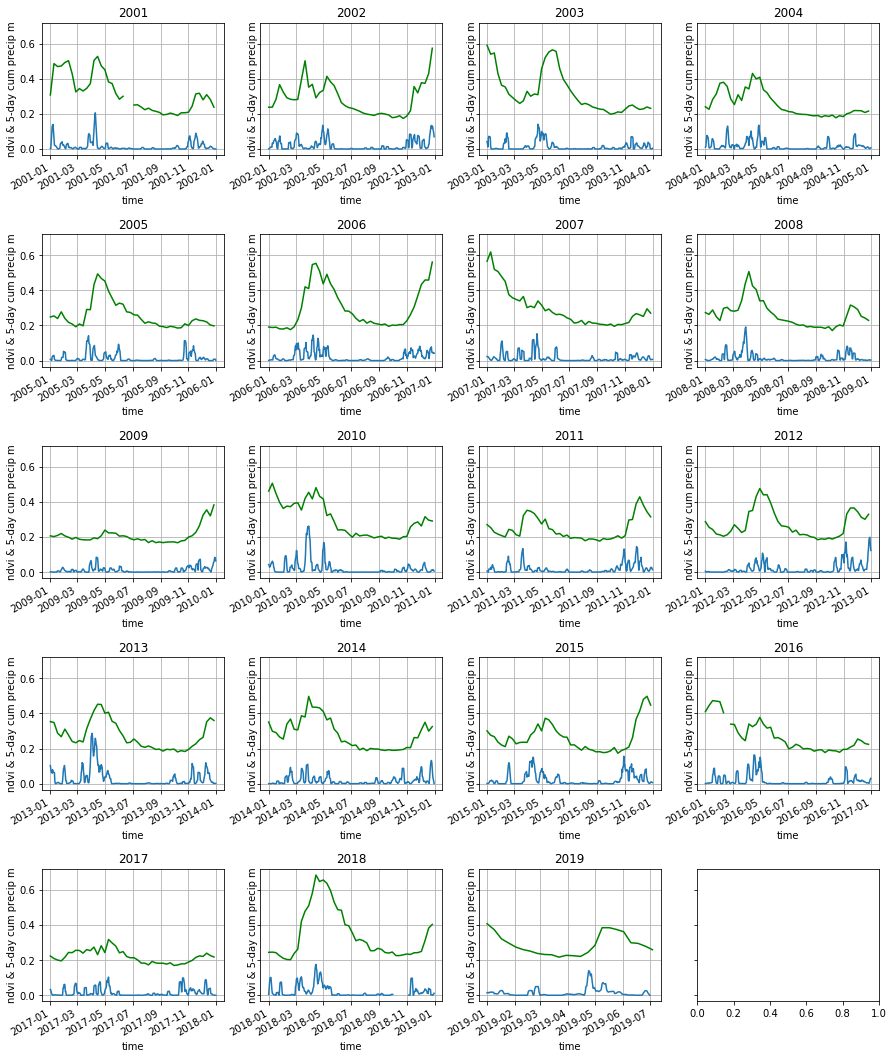

In [31]:
#plot NDVI and reanalysis precipitation per year

fig, axes = plt.subplots(5, 4, figsize=(15,18), sharey = True, gridspec_kw={'hspace': 0.6})
for (year, group), ax in zip(grouped, axes.flatten()):
    group.plot(ax=ax)
    ax.set_title(year)
    ax.set_ylabel('ndvi & 5-day cum precip mm')
for (year, group), ax in zip(grouped_ndvi, axes.flatten()):
    group.plot(ax=ax, color = 'g')
    ax.set_title(year)
    ax.set_ylabel(labelpad= 2, ylabel='ndvi & 5-day cum precip m')
    ax.grid(True)


## Forecast Bias Correction

In [32]:
#create interpoloation function for bias correction

def extrap1d(interpolator):
    xs = interpolator.x
    ys = interpolator.y

    def pointwise(x):
        if x < xs[0]:
            return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
        elif x > xs[-1]:
            return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
        else:
            return interpolator(x)

    def ufunclike(xs):
        return array(map(pointwise, array(xs)))

    return ufunclike

In [33]:
#Make a formula to select forecast data of one month for all the years 
## and perform the summation and mean calculations

def makeFC_93_15_17(year, begin, end):
    #Input data
    #Note: from 2017 onwards the ensamble size is 51, so this number should be changed in the FC code. 
    month = 3
    yr = year - 1993
    FC = ds_FC[yr] # Year - 1993

    #convert to dataframe
    ds_FC_date = FC.loc[dict(time=slice(begin, end), longitude=slice(36.7, 37.4), latitude=slice(-2.6, -3))]

    #calculate rolling 5-day cummulative rainfall minus evaporation
    ds_FC_tp = ds_FC_date['tp']# + FC_test['e']
    ds_FC_tp_diff = ds_FC_tp.diff(dim= 'time', n=1)
    ds_FC_e = ds_FC_date['e']# + FC_test['e']
    ds_FC_e_diff = ds_FC_e.diff(dim= 'time', n=1)
    ds_FC_PE = ds_FC_e_diff + ds_FC_tp_diff
    ds_FC_0 = xr.where(ds_FC_PE[:,:,:,:,:]<0, 0, ds_FC_PE)
    ds_FC_cum = ds_FC_0.rolling(time=5).sum()
    ds_FC_cum_0 = xr.where(ds_FC_cum[:,:,:,:,:]<0, 0, ds_FC_cum)
    cFC = mean_SA_era5(ds_FC_cum_0)
    
    return cFC

In [34]:
#Make a formula to select forecast data of one month for all the years 
## and perform the summation and mean calculations

def makeFC_16_18_19(year, begin, end):
    #Input data
    #Note: from 2017 onwards the ensamble size is 51, so this number should be changed in the FC code. 
    month = 3
    yr = year - 1993
    FC = ds_FC[yr] # Year - 1993

    #convert to dataframe
    ds_FC_date = FC.loc[dict(time=slice(begin, end), longitude=slice(36.7, 37.4), latitude=slice(-2.6, -3))]

    #calculate rolling 5-day cummulative rainfall minus evaporation
    ds_FC_tp = ds_FC_date['tp']# + FC_test['e']
    ds_FC_tp_diff = ds_FC_tp.diff(dim= 'time', n=1)
    ds_FC_e = ds_FC_date['e']# + FC_test['e']
    ds_FC_e_diff = ds_FC_e.diff(dim= 'time', n=1)
    ds_FC_PE = ds_FC_e_diff + ds_FC_tp_diff
    ds_FC_0 = xr.where(ds_FC_PE[:,:,:,:]<0, 0, ds_FC_PE)
    ds_FC_cum = ds_FC_0.rolling(time=5).sum()
    ds_FC_cum_0 = xr.where(ds_FC_cum[:,:,:,:]<0, 0, ds_FC_cum)
    cFC = mean_SA_era5(ds_FC_cum_0)
    
    return cFC

In [35]:
#load and merge all the forecast data chunks of the selected month
years = range(1993,2016)
FC_all = []
for year in years:
    start = date(year, 3, 2)
    end = date(year, 3, 28)
    FC = makeFC_93_15_17(year, start, end)
    FC_conc = xr.concat(FC[0,:,:], dim = 'time')
    FC_df = FC_conc.to_dataframe(name = 'P')
    FC_value = FC_df.values
    FC_1col = np.delete(FC_value, np.s_[0], axis = 1)
    FC_final = np.ndarray.flatten(FC_1col)
    FC_all.append(FC_final)
    FC_val_93_15 = np.concatenate(FC_all)

#since the forecast data from 2016, 2018 and 2019 
##  does not have system 4 data included anymore, 
##  the step to use only system 5 data is not required anymore
years = range(2016,2017)
FC_all = []
for year in years:
    start = date(year, 3, 2)
    end = date(year, 3, 28)
    FC = makeFC_16_18_19(year, start, end)
    FC_df = FC.to_dataframe(name = 'P')
    FC_value = FC_df.values
    FC_final = np.ndarray.flatten(FC_value)
    FC_all.append(FC_final)
    FC_val_16 = np.concatenate(FC_all)

# However, 2017 data does have system 4 in the dataset and thus 
##  requires the definition which is also used for the 1993-2015 data
years = range(2017,2018)
FC_all = []
for year in years:
    start = date(year, 3, 2)
    end = date(year, 3, 28)
    FC = makeFC_93_15_17(year, start, end)
    FC_conc = xr.concat(FC[0,:,:], dim = 'time')
    FC_df = FC_conc.to_dataframe(name = 'P')
    FC_value = FC_df.values
    FC_1col = np.delete(FC_value, np.s_[0], axis = 1)
    FC_final = np.ndarray.flatten(FC_1col)
    FC_all.append(FC_final)
    FC_val_17 = np.concatenate(FC_all)

years = range(2018,2020)
FC_all = []
for year in years:
    start = date(year, 3, 2)
    end = date(year, 3, 28)
    FC = makeFC_16_18_19(year, start, end)
    FC_df = FC.to_dataframe(name = 'P')
    FC_value = FC_df.values
    FC_final = np.ndarray.flatten(FC_value)
    FC_all.append(FC_final)
    FC_val_18_19 = np.concatenate(FC_all)

C:\Users\esmee\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
C:\Users\esmee\

C:\Users\esmee\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x

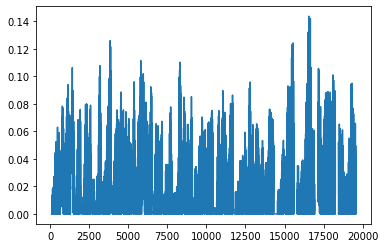

In [36]:
#make one long array of the FC data
P_fc = np.concatenate((FC_val_93_15, FC_val_16, FC_val_17, FC_val_18_19), axis = None)
plt.plot(P_fc)

In [37]:
# convert the reanalysis dataset to a slice of the year which will be analyzed 

def makeRE(year, begin, end):

    #convert to dataframe
    ds_RE_date = cTPE.loc[dict(time=slice(begin, end))]
    
    return ds_RE_date

In [38]:
#make one array of all the reanalysis data form the selected month
##  over all the years

years = range(1993,2020)
RE_all = []
for year in years:
    start = date(year, 3, 2)
    end = date(year, 3, 28)
    RE = makeRE(year, start, end)
    RE_all.append(RE)
    P_re = np.concatenate(RE_all)

In [39]:
# below the corresponding plotting positions are made 
##   (i.e. probabilities of non-exceedance)
q_re = np.linspace(1, len(P_re), len(P_re))/(len(P_re)+1)
P_fc_finite = P_fc[np.isfinite(P_fc)]
q_fc = np.linspace(1, len(P_fc_finite), len(P_fc_finite))/(len(P_fc_finite)+1)

Text(0, 0.5, 'Precipitation m/5-days')

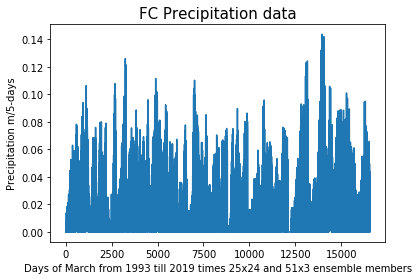

In [40]:
plt.plot(P_fc_finite)
# plt.plot(P_re)
# plt.title("Reanalysis Precipitation data", size=15)
plt.title("FC Precipitation data", size=15)
plt.xlabel("Days of March from 1993 till 2019 times 25x24 and 51x3 ensemble members")
plt.ylabel("Precipitation m/5-days")

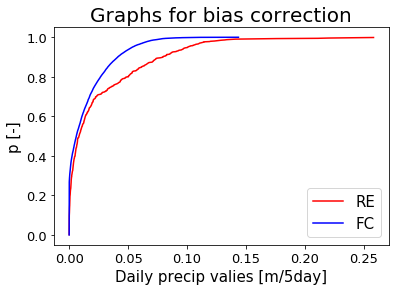

In [41]:
# Plot the reanalysis and forecast data of (sorted) precipitation
#  against the probability of non-exceedance

plt.plot(np.sort(P_re), q_re, label='RE', color = 'r')
plt.plot(np.sort(P_fc_finite), q_fc, label='FC', color = 'b')
plt.xlabel('5-day-sum precip values [m/5-day]')
plt.ylabel('p [-]')
plt.xticks(size = 13)
plt.yticks(size = 13)
plt.title('Graphs for bias correction', size = 20)
plt.xlabel('Daily precip valies [m/5day]', size = 15)
plt.ylabel('p [-]', size = 15)
plt.style.use('seaborn-dark-palette')
plt.legend(loc=4, prop={'size': 15})

In [42]:
#create the bias correction formula
interp_q_fc = intp.interp1d(np.sort(P_fc_finite), q_fc, fill_value='extrapolate')
interp_P_re = intp.interp1d(q_re, np.sort(P_re), fill_value='extrapolate')

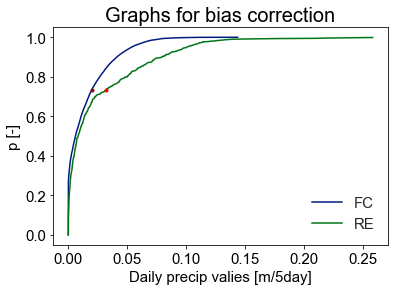

In [43]:
#plot the values corresponding to the interpolation formulas
#  to see whether it makes sense

q_interpolated = interp_q_fc([0.02])

P_interp = interp_P_re(q_interpolated)

plt.plot(np.sort(P_fc_finite), q_fc, label='FC')
plt.plot(np.sort(P_re), q_re, label='RE')
plt.plot([0.02], q_interpolated, '.')
plt.plot(P_interp, q_interpolated, 'r.')
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel('Daily precip valies [m/5day]', size = 15)
plt.ylabel('p [-]', size = 15)
plt.style.use('seaborn')
plt.title('Graphs for bias correction', size = 20)
plt.legend(loc=4, prop={'size': 15})

In [44]:
#take an example forecast and perform the bias correction

P_one_FC = makeFC_16_18_19(2018, '03/02/2018', '03/28/2018') 
P_one_FC = P_one_FC.to_dataframe(name = 'P')
P_one_fc = P_one_FC[np.isfinite(P_one_FC)]

def quantile_match(int_func_q, int_func_P, values):
    q_interp = int_func_q(values)
    P_interp = int_func_P(q_interp)
    
    return pd.DataFrame(P_interp.flatten(), index=values.index)

P_transformed = quantile_match(interp_q_fc, interp_P_re, P_one_fc)

P_trans = P_transformed.unstack(level=0).T
P_trans = P_trans.fillna(0)
P_FC = P_one_fc.unstack(level=0).T

P_FC = P_FC[4:]
P_trans = P_trans[4:]

C:\Users\esmee\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\esmee\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\esmee\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


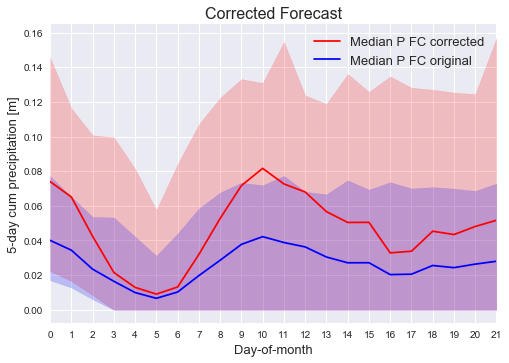

In [45]:
# Plot the example with the 95th and 5th percentiles
P_FC_95 = np.percentile(P_FC, 95, axis=1)
P_FC_5 = np.percentile(P_FC, 5, axis=1)
P_FC_med = np.median(P_FC, axis = 1)
P_FC_m = array(np.mean(P_FC, axis=1)) 
P_95 = np.percentile(P_trans, 95, axis=1)
P_5 = np.percentile(P_trans, 5, axis=1)
P_m = array(np.mean(P_trans, axis=1))
P_med = np.median(P_trans, axis = 1)
x = np.arange(0, 22, step=1)
alpha = 0.2

ax = plt.subplot()
plt.xticks(x)
plt.xlim(0, 21)
plt.fill_between(x, P_95, P_5, alpha=alpha, color='r', edgecolor=None)
plt.plot(P_med, label='Median P FC corrected', color = 'r')
plt.fill_between(x, P_FC_95, P_FC_5, alpha=alpha, color='b', edgecolor=None)
plt.plot(P_FC_med, label = 'Median P FC original', color = 'b')
plt.xlabel('Day-of-month', size = 13)
plt.ylabel('5-day cum precipitation [m]', size = 13)
plt.title('Corrected Forecast', size = 16)
plt.style.use('seaborn-dark-palette')
plt.legend(loc=1, prop={'size': 13})

plt.show()

In [46]:
#load all the forecast data chunks of the selected month 
#   before performing the bias correction
years = range(1993,2016)
FC_93_15 = []
for year in years:
    start = date(year, 3, 2)
    end = date(year, 3, 28)
    FC = makeFC_93_15_17(year, start, end)
    FC_conc = xr.concat(FC[0,:,:], dim = 'time')
    FC_df = FC_conc.to_dataframe(name = 'P')
    FC_93_15.append(FC_df)

# #since the forecast data from 2016, 2018, and 2019 do not have system 4 data included anymore, 
# ##the step to use only system 5 data is not required anymore
# from datetime import date
years = range(2016, 2017)
FC_16 = []
for year in years:
    start = date(year, 3, 2)
    end = date(year, 3, 28)
    FC = makeFC_16_18_19(year, start, end)
    FC_df = FC.to_dataframe(name = 'P')
    FC_16.append(FC_df)

# 2017 does still have system 4 data in the set which is removed
years = range(2017,2018)
FC_17 = []
for year in years:
    start = date(year, 3, 2)
    end = date(year, 3, 28)
    FC = makeFC_93_15_17(year, start, end)
    FC_conc = xr.concat(FC[0,:,:], dim = 'time')
    FC_df = FC_conc.to_dataframe(name = 'P')
    FC_17.append(FC_df)

years = range(2018,2020)
FC_18_19 = []
for year in years:
    start = date(year, 3, 2)
    end = date(year, 3, 28)
    FC = makeFC_16_18_19(year, start, end)
    FC_df = FC.to_dataframe(name = 'P')
    FC_18_19.append(FC_df)


C:\Users\esmee\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
C:\Users\esmee\

C:\Users\esmee\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
C:\Users\esmee\Anaconda3\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
C:\Users\esmee\

In [47]:
#create definitions for forecast bias correction

def FC_ens_93_15(year):
    yr = year - 1993
    P_one_fc = FC_93_15[yr]
    FC_in = P_one_fc.drop(['system'], axis=1)
    P_transformed = quantile_match(interp_q_fc, interp_P_re, FC_in)
    P_trans = P_transformed.unstack(level=0).T
    P_trans = P_trans.fillna(0)
    P_FC = FC_in.unstack(level=0).T
    return P_trans
    
def FC_ens_16(year):
    yr = year - 2016
    FC_in = FC_16[yr]
    P_transformed = quantile_match(interp_q_fc, interp_P_re, FC_in)
    P_trans = P_transformed.unstack(level=0).T
    P_trans = P_trans.fillna(0)
    P_FC = FC_in.unstack(level=0).T
    return P_trans

def FC_ens_17(year):
    yr = year - 2017
    P_one_fc = FC_17[yr]
    FC_in = P_one_fc.drop(['system'], axis=1)
    P_transformed = quantile_match(interp_q_fc, interp_P_re, FC_in)
    P_trans = P_transformed.unstack(level=0).T
    P_trans = P_trans.fillna(0)
    P_FC = FC_in.unstack(level=0).T
    return P_trans

def FC_ens_18_19(year):
    yr = year - 2018
    FC_in = FC_18_19[yr]
    P_transformed = quantile_match(interp_q_fc, interp_P_re, FC_in)
    P_trans = P_transformed.unstack(level=0).T
    P_trans = P_trans.fillna(0)
    P_FC = FC_in.unstack(level=0).T
    return P_trans


## ROC-diagram per threshold

In [48]:
#Set the threshold

th = 0.08

In [49]:
# match the forecast ensamble members with the reanalysis data
#  Did the precipitation in the month surpass the threshold at least once?
#  Then resanalysis = True
#  Did the precipitation of the forecasts ensamble surpass the threshold
#     at leats once too?
#  Then there is a hit.

def match(year, MonthDayYear_begin, MonthDayYear_end, th, FC_ens_formula):
    FC = FC_ens_formula(year)
    RE = makeRE(year,MonthDayYear_begin, MonthDayYear_end)
    th = th
    th_FC = threshold(FC, th)
    th_RE = threshold(RE, th)
    RE_result = th_RE.any()
    FC_result = th_FC.any(axis= 0)
    FC_result_df = DataFrame(FC_result, columns=['results'])

    if RE_result.values == False:
        FC_result_df.loc[FC_result_df.results == False, 'match'] = 'hit'
        FC_result_df.loc[FC_result_df.results == True, 'match'] = 'miss'
    else:
        FC_result_df.loc[FC_result_df.results == False, 'match'] = 'FA'
        FC_result_df.loc[FC_result_df.results == True, 'match'] = 'CN'   
    
    return FC_result_df

In [50]:
#Determine the hits, misses, FA, CN based on probabilities

def result(M, ens):
    M_t = M.match.str.split(expand=True).stack().value_counts()
    try:
        FA = M_t['FA']
        R_t = [] # result per AprilYear per probability
        for x in range(1,(ens+1)):
            p = x/ens
            if p <= FA/ens:
                R = 'FA'
            else:
                R = 'CN'
            R_t.append(R)
            R_tt = np.array(list(R_t))
            R_ttt = R_tt.T
    except KeyError:
        try:
            CN = M_t['CN']
            R_t = [] # result per AprilYear per probability
            for x in range(1,(ens+1)):
                R = 'CN'
                R_t.append(R)
                R_tt = np.array(list(R_t))
                R_ttt = R_tt.T
        except KeyError:
            try:
                Hit = M_t['hit']
                R_t = [] # result per AprilYear per probability
                for x in range(1,(ens+1)):
                    p = x/ens
                    if p <= Hit/ens:
                        R = 'Hit'
                    else:
                        R = 'Miss'
                    R_t.append(R)
                    R_tt = np.array(list(R_t))
                    R_ttt = R_tt.T
            except KeyError:
                Miss = M_t['miss']
                R_t = [] # result per AprilYear per probability
                for x in range(1,(ens+1)):
                    R = 'Miss'
                    R_t.append(R)
                    R_tt = np.array(list(R_t))
                    R_ttt = R_tt.T 
    return R_ttt

In [51]:
#Determine the hits, misses, FA, and CN for the ensamble members of the FC
M93 = match(1993, "03/02/1993", "03/28/1993", th, FC_ens_93_15)
M94 = match(1994, "03/02/1994", "03/28/1994", th, FC_ens_93_15)
M95 = match(1995, "03/02/1995", "03/28/1995", th, FC_ens_93_15)
M96 = match(1996, "03/02/1996", "03/28/1996", th, FC_ens_93_15)
M97 = match(1997, "03/02/1997", "03/28/1997", th, FC_ens_93_15)
M98 = match(1998, "03/02/1998", "03/28/1998", th, FC_ens_93_15)
M99 = match(1999, "03/02/1999", "03/28/1999", th, FC_ens_93_15)
M00 = match(2000, "03/02/2000", "03/28/2000", th, FC_ens_93_15)
M01 = match(2001, "03/02/2001", "03/28/2001", th, FC_ens_93_15)
M02 = match(2002, "03/02/2002", "03/28/2002", th, FC_ens_93_15)
M03 = match(2003, "03/02/2003", "03/28/2003", th, FC_ens_93_15)
M04 = match(2003, "03/02/2003", "03/28/2003", th, FC_ens_93_15)
M05 = match(2005, "03/02/2005", "03/28/2005", th, FC_ens_93_15)
M06 = match(2006, "03/02/2006", "03/28/2006", th, FC_ens_93_15)
M07 = match(2007, "03/02/2007", "03/28/2007", th, FC_ens_93_15)
M08 = match(2008, "03/02/2008", "03/28/2008", th, FC_ens_93_15)
M09 = match(2009, "03/02/2009", "03/28/2009", th, FC_ens_93_15)
M10 = match(2010, "03/02/2010", "03/28/2010", th, FC_ens_93_15)
M11 = match(2011, "03/02/2011", "03/28/2011", th, FC_ens_93_15)
M12 = match(2012, "03/02/2012", "03/28/2012", th, FC_ens_93_15)
M13 = match(2013, "03/02/2013", "03/28/2013", th, FC_ens_93_15)
M14 = match(2014, "03/02/2014", "03/28/2014", th, FC_ens_93_15)
M15 = match(2015, "03/02/2015", "03/28/2015", th, FC_ens_93_15)
M16 = match(2016, "03/02/2016", "03/28/2016", th, FC_ens_16)
M17 = match(2017, "03/02/2017", "03/28/2017", th, FC_ens_17)
M18 = match(2018, "03/02/2018", "03/28/2018", th, FC_ens_18_19)
M19 = match(2019, "03/02/2019", "03/28/2019", th, FC_ens_18_19)

C:\Users\esmee\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:609: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\esmee\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:612: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


In [52]:
# Calculate the hits, misses, FA, CN per year 
#    of the selected month per probability.
M93p = result(M93, 25)
M94p = result(M94, 25)
M95p = result(M95, 25) 
M96p = result(M96, 25)
M97p = result(M97, 25) 
M98p = result(M98, 25)
M99p = result(M99, 25)
M00p = result(M00, 25)
M01p = result(M01, 25) 
M02p = result(M02, 25)
M03p = result(M03, 25) 
M04p = result(M04, 25)
M05p = result(M05, 25) 
M06p = result(M06, 25)
M07p = result(M07, 25) 
M08p = result(M08, 25)
M09p = result(M09, 25) 
M10p = result(M10, 25)
M11p = result(M11, 25) 
M12p = result(M12, 25)
M13p = result(M13, 25) 
M14p = result(M14, 25)
M15p = result(M15, 25) 
M16p = result(M16, 25)
M17p = result(M17, 51)
M17p = np.delete(M17p, np.s_[25::]) #because 51 ensamble members i.s.o. 25
M18p = result(M18, 51)
M18p = np.delete(M18p, np.s_[25::]) #because 51 ensamble members i.s.o. 25
M19p = result(M19, 51)
M19p = np.delete(M19p, np.s_[25::]) #because 51 ensamble members i.s.o. 25

# Save the above results in one matrix
Results_all = np.c_[M93p, M94p, M95p, M96p, M97p, M98p, M99p, M00p, M01p, M02p, M03p, 
     M04p, M05p, M06p, M07p, M08p, M09p, M10p, M11p, M12p, M13p, M14p, 
     M15p, M16p,M17p, M18p, M19p]


In [53]:
# Compute the FA-rates and the Hit-rates per probability

FAr_p = np.array([])
Hr_p = np.array([])

for i in range(0,25):
    Results_s = pd.Series(list(Results_all))
    test = list(Results_s[i])
    FA =  test.count('FA')
    CN =  test.count('CN')
    Hit =  test.count('Hit')
    Miss = test.count('Miss')
    try:
        FAr_p_p = FA/(FA + CN)
    except ZeroDivisionError:
        FAr_p_p = 0
    try:
        Hr_p_p = Hit/(Hit + Miss)
    except ZeroDivisionError:
        Hr_p_p = 0
    FAr_p = np.append(FAr_p, FAr_p_p)
    Hr_p = np.append(Hr_p, Hr_p_p)
    
print('FAr_p', FAr_p)
print('Hr_p', Hr_p)

FAr_p [1.         1.         0.92857143 0.85714286 0.85714286 0.85714286
 0.78571429 0.57142857 0.57142857 0.57142857 0.42857143 0.42857143
 0.35714286 0.21428571 0.14285714 0.14285714 0.14285714 0.07142857
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.        ]
Hr_p [1.         1.         1.         0.92307692 0.92307692 0.92307692
 0.92307692 0.92307692 0.92307692 0.76923077 0.76923077 0.76923077
 0.76923077 0.76923077 0.76923077 0.69230769 0.46153846 0.46153846
 0.38461538 0.30769231 0.23076923 0.15384615 0.15384615 0.15384615
 0.15384615]


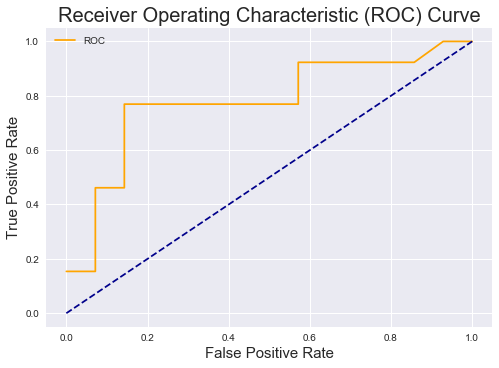

Precipitation Threshold non-exceedance sum of 5 days = 0.08 m


In [54]:
# Plot the ROC - diagram of the corresponding threshold
def plot_roc_curve(fpr, tpr): #where fpr=FA/(FA+CN) and tpr=Hit/(Hit+Miss)
    plt.style.use('seaborn')
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate', size = 15)
    plt.ylabel('True Positive Rate', size = 15)
    plt.title('Receiver Operating Characteristic (ROC) Curve', size = 20)
    plt.legend()
    plt.show()

plot_roc_curve(FAr_p, Hr_p)
print('Precipitation Threshold non-exceedance sum of 5 days =', th, 'm')

__Change threshold? Go to:[ROC-diagram per threshold](#ROC-diagram-per-threshold)__

## Bootstrapping

In [55]:
#create the bootstrapping samples

ds_FAr = []
for i in range(0,1000):
    FA_sample = np.random.choice(FAr_p, size=25)
    ds_FAr.append(FA_sample)

ds_Hr = []
for i in range(0,1000):
    H_sample = np.random.choice(Hr_p, size=25)
    ds_Hr.append(H_sample)

In [56]:
# Compute the area under the curve
Hr = np.append(Hr_p, 0) #to make sure the area is computed from the origin (0,0)
Hr = np.insert(Hr, 0, 1) #to make sure the area is computed up intil the top, right corner (1,1)
FAr = np.append(FAr_p, 0)
FAr = np.insert(FAr, 0, 1)
AUC = round(auc(FAr, Hr), ndigits=2)

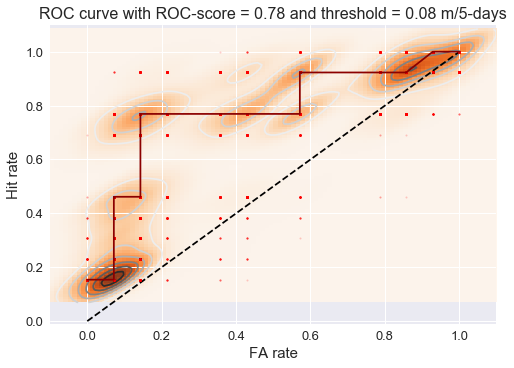

Precipitation Threshold non-exceedance sum of 5 days = 0.08 m


In [57]:
#plot the bootstrapped ROC-curve

x_FAr = np.concatenate(np.sort(ds_FAr))
y_Hr = np.concatenate(np.sort(ds_Hr))
x = x_FAr
y = y_Hr

# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

def density_estimation(m1, m2):
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = stats.gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z

X, Y, Z = density_estimation(x, y)

fig, ax = plt.subplots()                   

# Show density 
ax.imshow(np.rot90(Z), cmap='Oranges',                                                    
          extent=[xmin, xmax, ymin, ymax], alpha = 0.9, aspect = 'auto')
# Add contour lines
plt.contour(X, Y, Z, alpha=1)                                                                           
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
ax.plot(x, y, 'r.', markersize=4, alpha = 0.2)
ax.plot(FAr_p, Hr_p, color = 'darkred')
plt.xticks(size = 13)
plt.yticks(size = 13)
ax.set_xlim([-0.1, 1.1])                                                                           
ax.set_ylim([-.01, 1.1])                                                                           
ax.set_xlabel('FA rate', size = 15)
ax.set_ylabel('Hit rate', size = 15)
plt.title('ROC curve with ROC-score = {} and threshold = {} m/5-days'.format(AUC, th), size = 16)
plt.show()

print('Precipitation Threshold non-exceedance sum of 5 days =', th, 'm')

## Plotting FC values against RE values

In [58]:
#Prepare data 

#select the first year of the forecast data (1993)
P_fc_1 = P_fc_finite[:550]

#sort the forecast data on ensemble member
AR_25 = np.array(range(0,25))
ARray25 = []
P_FC_new_1 = []


for i in AR_25:
    ARR25 = np.array(range(i,550,25))

    for i in ARR25:
        P_FC_index = P_fc_1[i]
        P_FC_new_1.append(P_FC_index)

#select the first 22 days of the reanalysis data as the forecast data is also of the first 22 days
P_re_1 = P_re[:22]

#create an array of reanalysis data which can be overlayed with the array of forecast data
##so multiply the reanalysis array by 25 (ensemble members)
P_re_11 = [P_re_1]*25
P_re_111 = np.concatenate(P_re_11)

###Repeat the above procedure for 1994, 1995, 1996

P_fc_2 = P_fc_finite[550:1100]

AR_25 = np.array(range(0,25))
ARray25 = []
P_FC_new_2 = []

for i in AR_25:
    ARR25 = np.array(range(i,550,25))

    for i in ARR25:
        P_FC_index = P_fc_2[i]
        P_FC_new_2.append(P_FC_index)
        
P_re_2 = P_re[27:54]
P_re_2 = P_re_2[:22]
P_re_22 = [P_re_2]*25
P_re_222 = np.concatenate(P_re_22)

### 1995

P_fc_3 = P_fc_finite[1100:1650]

AR_25 = np.array(range(0,25))
ARray25 = []
P_FC_new_3 = []

for i in AR_25:
    ARR25 = np.array(range(i,550,25))

    for i in ARR25:
        P_FC_index = P_fc_3[i]
        P_FC_new_3.append(P_FC_index)
        
P_re_3 = P_re[54:81]
P_re_3 = P_re_3[:22]
P_re_33 = [P_re_3]*25
P_re_333 = np.concatenate(P_re_33)

### 1996

P_fc_4 = P_fc_finite[1650:2200]

AR_25 = np.array(range(0,25))
ARray25 = []
P_FC_new_4 = []

for i in AR_25:
    ARR25 = np.array(range(i,550,25))

    for i in ARR25:
        P_FC_index = P_fc_4[i]
        P_FC_new_4.append(P_FC_index)
        
P_re_4 = P_re[81:108]
P_re_4 = P_re_4[:22]
P_re_44 = [P_re_4]*25
P_re_444 = np.concatenate(P_re_44)

### All years together 1993-1996
P_re_4yr = [P_re_111]+[P_re_222]+[P_re_333]+[P_re_444]
P_re_4y = np.concatenate(P_re_4yr)
P_fc_4yr = [P_FC_new_1]+[P_fc_2]+[P_fc_3]+[P_fc_4]
P_fc_4y = np.concatenate(P_fc_4yr)

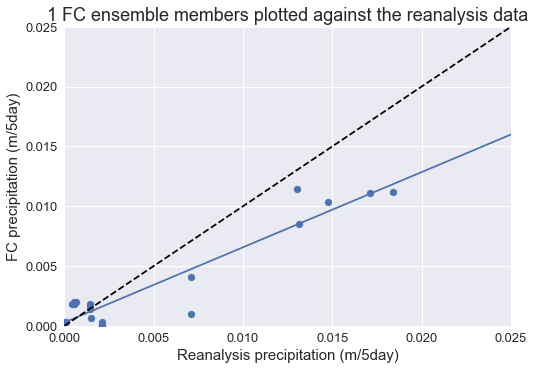

In [96]:
#Plot one or several FC ensemble members against the RE data of one year (1993)

P_fc_new1 = P_FC_new_1[0:22] #ensemble member 1
P_fc_new2 = P_FC_new_1[22:44] #ensemble member 2
P_fc_new3 = P_FC_new_1[44:66] #ensenmble member 3
P_fc_new4 = P_FC_new_1[88:110] #ensemble member 5

# X = P_re_1 #reanalysis data 1993
# Y = P_fc_new1 #fc ensemble member 1 1993

# results = sm.OLS(Y,sm.add_constant(X)).fit() 
# # print(results.summary())
# plt.scatter(X,Y)
# X_plot = np.linspace(0,0.025,100)
# plt.plot(X_plot, X_plot*results.params[1] + results.params[0], label = "ens member 1")
plt.xlim(0,0.025)
plt.ylim(0,0.025)

##########
## The code below can be deselected to add other ensemble members to the graph
##########

#### Add ensemble member 2
X = P_re_1
Y = P_fc_new2
results = sm.OLS(Y,sm.add_constant(X)).fit()
plt.scatter(X,Y)
X_plot = np.linspace(0,0.025,100)
plt.plot(X_plot, X_plot*results.params[1] + results.params[0], label = "ens member 2")

# #### Add ensemble member 3
# X = P_re_1
# Y = P_fc_new3
# results = sm.OLS(Y,sm.add_constant(X)).fit()
# plt.scatter(X,Y)
# X_plot = np.linspace(0,0.025,100)
# plt.plot(X_plot, X_plot*results.params[1] + results.params[0], label = "ens member 3")

# #### Add ensemble member 4
# X = P_re_1
# Y = P_fc_new4
# results = sm.OLS(Y,sm.add_constant(X)).fit()
# plt.scatter(X,Y)
# X_plot = np.linspace(0,0.025,100)
# plt.plot(X_plot, X_plot*results.params[1] + results.params[0], label = "ens member 4")

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title("1 FC ensemble members plotted against the reanalysis data", size=18)
plt.xlabel('Reanalysis precipitation (m/5day)', size = 15)
plt.ylabel('FC precipitation (m/5day)', size = 15)
plt.xticks(size = 13)
plt.yticks(size = 13)
# plt.legend(loc='upper left', frameon=bool, fontsize = 'xx-large')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     11.49
Date:                Sat, 07 Dec 2019   Prob (F-statistic):           0.000748
Time:                        15:11:19   Log-Likelihood:                 1686.7
No. Observations:                 550   AIC:                            -3369.
Df Residuals:                     548   BIC:                            -3361.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0057      0.001      9.261      0.0

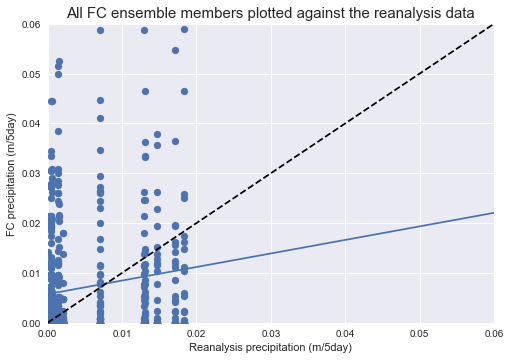

In [77]:
#plot all FC ensemble members against the RE of one year (1993)

X = P_re_111 #Reanalysis data 1993 (array x 25 to lay over the FC data)
Y = P_FC_new_1 #FC data all ensemble members (25) 1993

results = sm.OLS(Y,sm.add_constant(X)).fit()
print(results.summary())
plt.scatter(X,Y)
X_plot = np.linspace(0,0.06,100)
plt.plot(X_plot, X_plot*results.params[1] + results.params[0])
plt.xlim(0,0.06)
plt.ylim(0,0.06)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title("All FC ensemble members plotted against the reanalysis data", size=15)
plt.xlabel('Reanalysis precipitation (m/5day)')
plt.ylabel('FC precipitation (m/5day)')
plt.show()


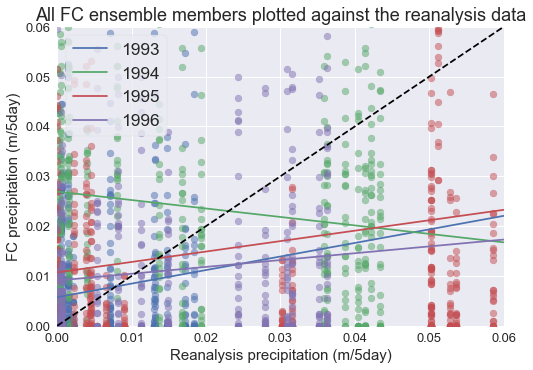

In [99]:
#Plot several years of FC and RE data

## 1993
X = P_re_111
Y = P_FC_new_1
results = sm.OLS(Y,sm.add_constant(X)).fit()
# print(results.summary())
plt.scatter(X,Y, alpha = 0.5)
X_plot = np.linspace(0,0.06,100)
plt.plot(X_plot, X_plot*results.params[1] + results.params[0], label = '1993')

## 1994
X = P_re_222
Y = P_FC_new_2
results = sm.OLS(Y,sm.add_constant(X)).fit()
# print(results.summary())
plt.scatter(X,Y, alpha = 0.5)
X_plot = np.linspace(0,0.06,100)
plt.plot(X_plot, X_plot*results.params[1] + results.params[0], label = '1994')

## 1995
X = P_re_333
Y = P_FC_new_3
results = sm.OLS(Y,sm.add_constant(X)).fit()
# print(results.summary())
plt.scatter(X,Y, alpha = 0.5)
X_plot = np.linspace(0,0.06,100)
plt.plot(X_plot, X_plot*results.params[1] + results.params[0], label = '1995')

## 1996
X = P_re_444
Y = P_FC_new_4
results = sm.OLS(Y,sm.add_constant(X)).fit()
# print(results.summary())
plt.scatter(X,Y, alpha = 0.5)
X_plot = np.linspace(0,0.06,100)
plt.plot(X_plot, X_plot*results.params[1] + results.params[0], label = '1996')

plt.xlim(0,0.06)
plt.xticks(size = 13)
plt.ylim(0,0.06)
plt.yticks(size = 13)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title("All FC ensemble members plotted against the reanalysis data", size=18)
plt.xlabel('Reanalysis precipitation (m/5day)', size = 15)
plt.ylabel('FC precipitation (m/5day)', size = 15)
plt.legend(loc='upper left', frameon=bool, fontsize = 'xx-large')
plt.show()

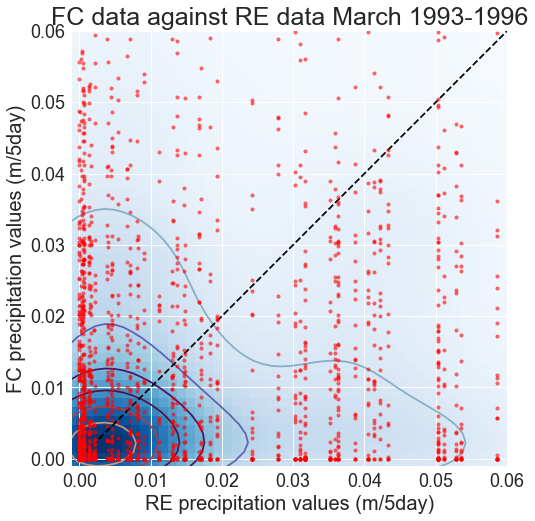

In [107]:
#plot the 4-years FC and RE data with density curves

x = P_re_4y
y = P_fc_4y

# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

def density_estimation(m1, m2):
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = stats.gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z

X, Y, Z = density_estimation(x, y)

fig, ax = plt.subplots(figsize=(8,8))                   

# Show density 
ax.imshow(np.rot90(Z), cmap='Blues',                                                    
          extent=[xmin, xmax, ymin, ymax], alpha = 1, aspect = 'equal')

# Add contour lines
plt.contour(X, Y, Z, alpha=1, cmap = 'twilight')                                                                           
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
ax.plot(x, y, 'r.', markersize=8, alpha = 0.6)
plt.xticks(size = 18)
plt.yticks(size = 18)
ax.set_xlim([-0.001, 0.06])                                                                           
ax.set_ylim([-0.001, 0.06])                                                                           
ax.set_xlabel('RE precipitation values (m/5day)', size = 20)
ax.set_ylabel('FC precipitation values (m/5day)', size = 20)
plt.title('FC data against RE data March 1993-1996', size=25)
plt.show()